In [1]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, make_scorer,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier  # Assuming you are using XGBoost for classification; use XGBRegressor for regression
import xgboost as xgb 

from sklearn.metrics import confusion_matrix

import pprint
from tabulate import tabulate

from sklearn import linear_model

from imblearn.over_sampling import SMOTE
# if there is an error, solve by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''


# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

# Data Pre-Processing

1. Removed variables that are redundant and uncorrelated to the dependent variable such as ID, year. 
2. Removed the NAs. 

In [2]:

# 1. Upload the dataset 
df = pd.read_csv('Loan_Default.csv')
# 2. remove some variables that are redundant such as year, ID
# 3. Removed Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# 4. Removed open credit , secured by, total units : only has one value or too few observations 
df = df.drop(['year', 'ID', 'loan_type', 'loan_purpose', 'Interest_rate_spread', 
              'rate_of_interest', 'open_credit','Upfront_charges','construction_type', 
              'Secured_by', 'Security_Type','total_units'], axis=1)

# 5. Removed NAs 
df = df.dropna(subset=["property_value"])
df = df.dropna(subset=["term"])
df = df.dropna(subset=["loan_limit"])
df = df.dropna(subset=["approv_in_adv"])
df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["income"])
# Drop rows where sex is not available 
df = df.drop(df[df['Gender'] == 'Not Available'].index)


## Imbalanced dataset 
Now we check if the dataset is imbalanced or not. As shown below, it is heavily imbalanced where the minority class (default) has fewer observations than the non-defaulters. 

In [4]:
print(df['Status'].value_counts())

0    100978
1     19657
Name: Status, dtype: int64


### Dealing with categorical values 

We deal with categorical value by turning it into dummy variable. 

In [3]:

# We turn these columns into dummy variables since they are categorical and drop the original column in the dataframe 
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'Credit_Worthiness',
       'business_or_commercial', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'occupancy_type',
        'credit_type', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'Region']

for i in categorical_columns: 
    df = pd.concat([df,pd.get_dummies(df[i],drop_first=True, prefix=i)],axis=1)
    df = df.drop(i,axis=1)


# Checking Correlation between values 

We check for multi-colinearity between variables. 

In [4]:
correlation_matrix = df.corr()

# Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Check for high absolute correlation coefficients
threshold = 0.8 
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


In [5]:
if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


# Split Train Test dataset



In [6]:
# define X and y variables as dataframe 
y = df['Status']
X = df.drop('Status',axis=1)
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

## Over Sampling using SMOTE

Since we know previously that our data is hihgly imbalanced, we use SMOTE to help us decrease the bias and to help the model learn to identify the minority class. 


In [9]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
# X_smote, y_smote = sm.fit_resample(X_train, y_train)

## Setup K-Fold Cross Validation 

In [7]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)



# Model 1 : Linear Regressions (with LASSO and Ridge Regression) 

## Cross Validation for LASSO 

In [10]:
# Model 2 : LASSO 
# Cross Validate the penalty term in lasso
cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
lambdas = [0.001, 0.01, 0.1]
for lambda_value in lambdas:
    print('Training Lasso Lambda Value : ', lambda_value)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    lasso = linear_model.Lasso(alpha=lambda_value)
    for train_index, test_index in cv.split(X_train):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
        # TODO 
        X_cv_train, y_cv_train = sm.fit_resample(X_cv_train, y_cv_train)
        lasso.fit(X_cv_train, y_cv_train)
        y_pred = lasso.predict(X_cv_test)
        y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]

        #Cross-Validation Prediction Error
        score = lasso.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred_classification))
        precision_scores.append(precision_score(y_cv_test,y_pred_classification))

    cross_validate_result[lambda_value] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[lambda_value] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[lambda_value] = (sum(precision_scores)/len(precision_scores))

    print("Lambda Value Accuracy : " + str(lambda_value) + " " + str((sum(accuracies)/len(accuracies))))
    print("Lambda Value Precision : " + str(lambda_value) + " " + str((sum(recall_scores)/len(recall_scores))))
    print("Lambda Value Recall : " + str(lambda_value) + " " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Training Lasso Lambda Value :  0.001
Lambda Value Accuracy : 0.001 -0.19562619025909167
Lambda Value Precision : 0.001 0.21223258632132094
Lambda Value Recall : 0.001 0.26908015235626387

Training Lasso Lambda Value :  0.01
Lambda Value Accuracy : 0.01 -0.27330212068814547
Lambda Value Precision : 0.01 0.27020628529749374
Lambda Value Recall : 0.01 0.2679974426320605

Training Lasso Lambda Value :  0.1
Lambda Value Accuracy : 0.1 -0.7700647651789144
Lambda Value Precision : 0.1 0.5973635552644045
Lambda Value Recall : 0.1 0.21604385712935828

------------------
Accuracy :  {0.001: -0.19562619025909167, 0.01: -0.27330212068814547, 0.1: -0.7700647651789144}
Precision :  {0.001: 0.26908015235626387, 0.01: 0.2679974426320605, 0.1: 0.21604385712935828}
Recall :  {0.001: 0.21223258632132094, 0.01: 0.27020628529749374, 0.1: 0.5973635552644045}


## LASSO vs Ridge vs OLS

In [12]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS OOS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("OLS OOS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO OOS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("LASSO OOS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))
print("--")

# RIDGE 
ridge = linear_model.Ridge(alpha=3)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge OOS Model Recall : " , recall_score(y_OOS_test, y_pred_classification))
print("Ridge OOS Model Precision : ", precision_score(y_OOS_test,y_pred_classification))

OLS OOS Model Recall :  0.18342597271349168
OLS OOS Model Precision :  0.24568527918781727
--
LASSO score : 
LASSO OOS Model Recall :  0.2561899949469429
LASSO OOS Model Precision :  0.25814663951120165
--
Ridge OOS Model Recall :  0.18342597271349168
Ridge OOS Model Precision :  0.24576844955991875


## Plot the ROC Curve

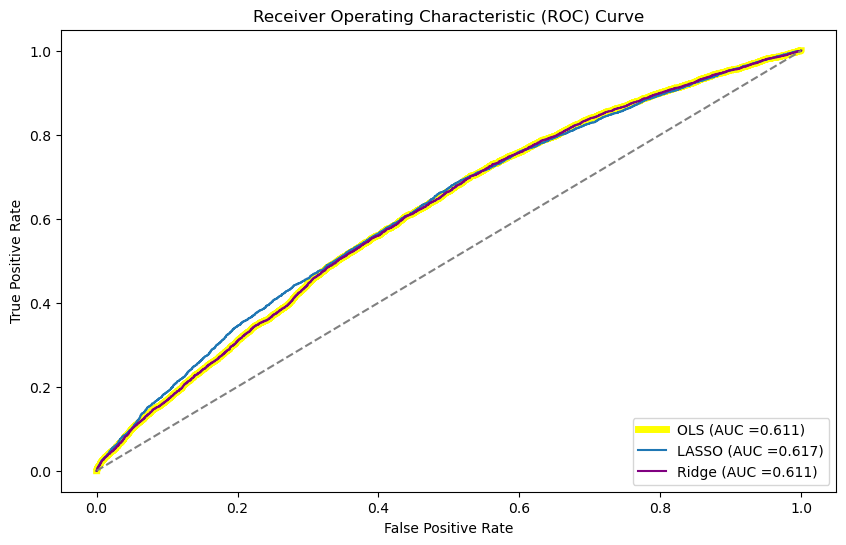

In [14]:
# OLS
y_pred_ols = ols.predict(X_OOS_test)
fpr_ols, tpr_ols, _ = roc_curve(y_OOS_test, y_pred_ols)
roc_auc_ols = auc(fpr_ols, tpr_ols)

# LASSO
y_pred_lasso = lasso.predict(X_OOS_test)
fpr_lasso, tpr_lasso, _ = roc_curve(y_OOS_test, y_pred_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

# RIDGE
y_pred_ridge = ridge.predict(X_OOS_test)
fpr_ridge, tpr_ridge, _ = roc_curve(y_OOS_test, y_pred_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_ols, tpr_ols, lw=5,color = 'yellow', label='OLS (AUC ='+str(round(roc_auc_ols, 3))+')')
plt.plot(fpr_lasso, tpr_lasso,label='LASSO (AUC ='+str(round(roc_auc_lasso, 3))+')')
plt.plot(fpr_ridge, tpr_ridge,color='purple', label='Ridge (AUC ='+str(round(roc_auc_ridge, 3))+')')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Model 2 : Random Forest

In [11]:

random_forest = RandomForestClassifier(n_estimators = 200, max_depth=5, random_state=0)
random_forest.fit(X_smote, y_smote)

y_pred = random_forest.predict(X_OOS_test)
print("RND Forest Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("RND Forest Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))
print("RND Forest F1 : ", f1_score(y_OOS_test,y_pred))
print("RND Forest MSE : ", mean_squared_error(y_OOS_test,y_pred))

RND Forest Accuracy :  0.7620093670991006
RND Forest Recall :  0.38100050530570995
RND Forest Precision :  0.31416666666666665
RND Forest F1 :  0.34437086092715224
RND Forest MSE :  0.23799063290089942


In [ ]:
# Cross Validate Random Forest
param_grid = [{'n_estimators': [200,225,250], 'max_depth' :[10,20,30]}]
random_forest_cv = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=random_forest_cv, cv=cv, param_grid=param_grid, n_jobs = 3)
grid_cv.fit(X_smote, y_smote)

In [20]:
def create_dictionary(param_1,param_2):
    result_dictionary = {} 
    for i in param_1: 
        result_dictionary[i] = {} 
        for j in param_2: 
                result_dictionary[i][j] = {} 
    return result_dictionary

### 2.1 Random Forest Cross Validation

In [19]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [5,10,20]
number_of_trees = [50,100,150] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  5  Number of Trees  50
Accuracy : 0.8141852705484677
Precision : 0.7881121263025624
Recall : 0.8315359661942878

Depth of Tree :  10  Number of Trees  50
Accuracy : 0.8450853249634077
Precision : 0.8061433201371495
Recall : 0.8742650039894032

Depth of Tree :  20  Number of Trees  50
Accuracy : 0.8788006504754711
Precision : 0.8353310607835125
Recall : 0.9148718603472066

Depth of Tree :  5  Number of Trees  100
Accuracy : 0.8141296128929836
Precision : 0.7926328670931586
Recall : 0.828293501300954

Depth of Tree :  10  Number of Trees  100
Accuracy : 0.8460691386005099
Precision : 0.8060760939800934
Recall : 0.8761503618455437

Depth of Tree :  20  Number of Trees  100
Accuracy : 0.8806630636515823
Precision : 0.8373464913765325
Recall : 0.9167712338420448

Depth of Tree :  5  Number of Trees  150
Accuracy : 0.8151258159757276
Precision : 0.7922083818503254
Recall : 0.8303246535176146

Depth of Tree :  10  Number of Trees  150
Accuracy : 0.8473004314286632
Precision :

# Model 3 : KNN 

The cross validation results indicated that 3 (neighbours) is the most optimal number. 

In [65]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_smote, y_smote)
# Make predictions on the test data
y_pred = knn.predict(X_OOS_test)
# Evaluate the accuracy of the classifier
print("KNN Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("KNN Recall : " , recall_score(y_OOS_test, y_pred))
print("KNN Precision : ", precision_score(y_OOS_test,y_pred))
print("KNN F1 : ", f1_score(y_OOS_test,y_pred))

KNN Accuracy :  0.6375430016164463
KNN Recall :  0.4373420919656392
KNN Precision :  0.20984361740817067
KNN F1 :  0.28360776603588106


## Cross Validation for KNN 

In [129]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
number_of_neighbours = [1,2,5,10,20] 

cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

for neighbour in number_of_neighbours: 
    print('Number of Neighbours : ', neighbour)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    knn = KNeighborsClassifier(n_neighbors=neighbour)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        knn.fit(X_cv_train, y_cv_train)
        y_pred = knn.predict(X_cv_test)

        #Cross-Validation Prediction Error
        score = knn.score(X_cv_test, y_cv_test)
        accuracies.append(score)
        recall_scores.append(recall_score(y_cv_test, y_pred))
        precision_scores.append(precision_score(y_cv_test,y_pred))
    
    cross_validate_result[neighbour] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[neighbour] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[neighbour] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
    print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
    print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
    print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Number of Neighbours :  1
Accuracy : 0.7491306930716343
Precision : 0.7913814929899982
Recall : 0.7297182708745649

Number of Neighbours :  2
Accuracy : 0.7208912490896946
Precision : 0.6143489063987174
Recall : 0.7807035859110011

Number of Neighbours :  5
Accuracy : 0.7150626918813072
Precision : 0.7600030502917845
Recall : 0.6973337101550398

Number of Neighbours :  10
Accuracy : 0.6934252546752455
Precision : 0.6760488446216651
Recall : 0.7003987598554531

Number of Neighbours :  20
Accuracy : 0.6729262988530459
Precision : 0.6758568740529208
Recall : 0.6719393446404093

------------------
Accuracy :  {1: 0.7491306930716343, 2: 0.7208912490896946, 5: 0.7150626918813072, 10: 0.6934252546752455, 20: 0.6729262988530459}
Precision :  {1: 0.7297182708745649, 2: 0.7807035859110011, 5: 0.6973337101550398, 10: 0.7003987598554531, 20: 0.6719393446404093}
Recall :  {1: 0.7913814929899982, 2: 0.6143489063987174, 5: 0.7600030502917845, 10: 0.6760488446216651, 20: 0.6758568740529208}


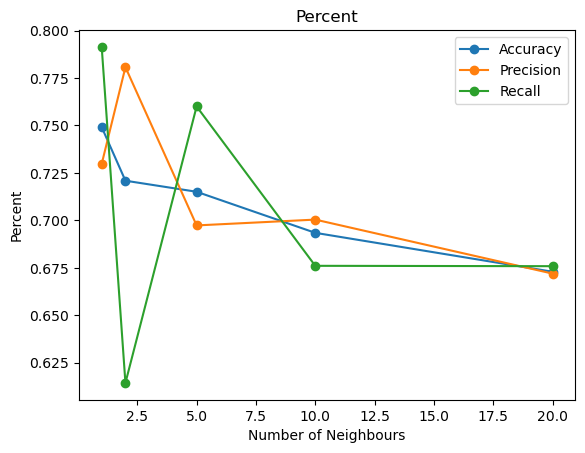

In [130]:
# # Plotting a line plot
# print(cross_validate_precision)
array = {'Accuracy' :  cross_validate_result, 
        'Precision' :  cross_validate_precision ,
        'Recall' :  cross_validate_recall}
pd.DataFrame(array).plot(kind='line', marker='o')
# Display the plot
plt.title('Percent')
plt.xlabel('Number of Neighbours')
plt.ylabel('Percent')
plt.show()

# Model 5 : LASSO and Random Forest

In [31]:
# LASSO 
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_OOS_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
# See LASSO coefficient that is 0 
lasso_coefficients = pd.Series(lasso.coef_)
non_zero_lasso_coefficients = lasso_coefficients[lasso_coefficients != 0]

Let's see which variables LASSO did not decrease to 0. 

In [32]:
column_names = df.drop('Status', axis=1).columns
lasso_col_names = []
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        lasso_col_names.append(column_names[i])
        print(column_names[i], ' : ' , lasso.coef_[i])

print(lasso_col_names)

loan_amount  :  -5.816113360981448e-08
term  :  -0.0001995884378351399
property_value  :  1.1366373088839135e-07
income  :  -2.8484234173342674e-06
Credit_Score  :  1.5168029461767876e-05
LTV  :  0.0023575462464294904
dtir1  :  0.0022116553252926768
Gender_Joint  :  -0.16993308046198513
Gender_Male  :  -0.18190660170861853
Gender_Sex Not Available  :  -0.08075185921184395
approv_in_adv_pre  :  -0.0949568631991573
business_or_commercial_nob/c  :  -0.11911310513936454
Neg_ammortization_not_neg  :  -0.16050474842638116
lump_sum_payment_not_lpsm  :  -0.15365042821849476
occupancy_type_pr  :  -0.07244593801328064
credit_type_CRIF  :  -0.12114639088619054
credit_type_EXP  :  -0.12154764392055876
co-applicant_credit_type_EXP  :  -0.10966368228453498
age_35-44  :  -0.1974254103427515
age_45-54  :  -0.17391983421791044
age_55-64  :  -0.14874290251309472
age_65-74  :  -0.11881749043666376
Region_south  :  -0.04644224602980309
['loan_amount', 'term', 'property_value', 'income', 'Credit_Score', 'L

In [144]:
X_lasso_rf_train = X_smote[lasso_col_names]
X_lasso_rf_test = X_OOS_test[lasso_col_names]
random_forest = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_lasso_rf_train, y_smote)
y_pred = random_forest.predict(X_lasso_rf_test)
print("RND Forest Model Recall : " , recall_score(y_OOS_test, y_pred))
print("RND Forest Precision : ", precision_score(y_OOS_test,y_pred))
print("RND Forest and LASSO MSE : ", mean_squared_error(y_OOS_test,y_pred))
print("RND Forest and LASSO f1 : ", f1_score(y_OOS_test,y_pred))


RND Forest Model Recall :  0.6139464375947449
RND Forest Precision :  0.23610571317528178
RND Forest and LASSO MSE :  0.38919053342728066
RND Forest and LASSO f1 :  0.3410526315789474


## Cross Validation for LASSO and randomforest

In [64]:
# CV in Trees  
# Set Hyperparameter (Lambda) values to cross validate here !!!!! 
max_depth = [2, 3, 4]
number_of_trees = [5,10,15] 

cross_validate_result = create_dictionary(number_of_trees,max_depth)
cross_validate_recall = create_dictionary(number_of_trees,max_depth)
cross_validate_precision = create_dictionary(number_of_trees,max_depth) 

for tree in number_of_trees: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        random_forest_cv = RandomForestClassifier(n_estimators = tree, max_depth=depth)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_lasso_rf_train.iloc[train_index], X_lasso_rf_train.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            random_forest_cv.fit(X_cv_train, y_cv_train)
            y_pred = random_forest_cv.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[tree][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  2  Number of Trees  5
Accuracy : 0.5898970807910194
Precision : 0.5600514433592819
Recall : 0.5960859138716283

Depth of Tree :  3  Number of Trees  5
Accuracy : 0.6028969716073906
Precision : 0.6320289001728526
Recall : 0.5975296460241809

Depth of Tree :  4  Number of Trees  5
Accuracy : 0.6066650987112998
Precision : 0.598612368126647
Recall : 0.6089193795794439

Depth of Tree :  2  Number of Trees  10
Accuracy : 0.5953731298159273
Precision : 0.6041965507061027
Recall : 0.593735225239221

Depth of Tree :  3  Number of Trees  10
Accuracy : 0.6015109811705502
Precision : 0.6334501039068922
Recall : 0.5955423320631559

Depth of Tree :  4  Number of Trees  10
Accuracy : 0.6084904183967266
Precision : 0.6153576420941061
Recall : 0.6072664926564537

Depth of Tree :  2  Number of Trees  15
Accuracy : 0.5956700913690367
Precision : 0.5658451977712038
Recall : 0.6022292393645742

Depth of Tree :  3  Number of Trees  15
Accuracy : 0.603589981948197
Precision : 0.629917915617

# Model 6 : Gradient Boosting 

From the results above, we see that the OOS results could do a lot better. In this next model, we tried the 

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=0).fit(X_smote, y_smote)
y_pred = clf.predict(X_OOS_test)
print("Gradient Boosting Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Gradient Boosting Recall : " , recall_score(y_OOS_test, y_pred))
print("Gradient Boosting Precision : ", precision_score(y_OOS_test,y_pred))
print("Gradient Boosting f1 : ", f1_score(y_OOS_test,y_pred))
print("Gradient Boosting Mean Squared Error : ", mean_squared_error(y_OOS_test,y_pred))

Gradient Boosting Accuracy :  0.8529862809300783
Gradient Boosting Recall :  0.3309752400202122
Gradient Boosting Precision :  0.5930285196921684
Gradient Boosting f1 :  0.4248419004378141
Gradient Boosting Mean Squared Error :  0.14701371906992167


## Cross Validation for Gradient Boosting

In [22]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0.01,0.1,0.5]
max_depth = [3,5]

cross_validate_result = create_dictionary(learning_rates,max_depth)
cross_validate_recall = create_dictionary(learning_rates,max_depth)
cross_validate_precision = create_dictionary(learning_rates,max_depth) 

for rate in learning_rates: 
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=rate, max_depth=depth, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            clf.fit(X_cv_train, y_cv_train)
            y_pred = clf.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = clf.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][depth] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][depth] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][depth] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  3  Learning rate  0.01
Accuracy : 0.7767389544932674
Precision : 0.7838862288907824
Recall : 0.7728541682170349

Depth of Tree :  5  Learning rate  0.01
Accuracy : 0.812397141022144
Precision : 0.7909555946935181
Recall : 0.8264105389470753

Depth of Tree :  3  Learning rate  0.1
Accuracy : 0.8604672827690175
Precision : 0.826632744327712
Recall : 0.8866323853623914

Depth of Tree :  5  Learning rate  0.1
Accuracy : 0.8805887991440562
Precision : 0.844553733411118
Recall : 0.9101551190817162

------------------
Accuracy :  {0.01: {3: 0.7767389544932674, 5: 0.812397141022144}, 0.1: {3: 0.8604672827690175, 5: 0.8805887991440562}}
Precision :  {0.01: {3: 0.7728541682170349, 5: 0.8264105389470753}, 0.1: {3: 0.8866323853623914, 5: 0.9101551190817162}}
Recall :  {0.01: {3: 0.7838862288907824, 5: 0.7909555946935181}, 0.1: {3: 0.826632744327712, 5: 0.844553733411118}}


In [17]:
def plot_result(dataframe, X_axis, Y_axis, title):
    results = pd.DataFrame.from_dict(dataframe, orient='index')
    # # Plotting a line plot
    results.plot(kind='line', marker='o')

    # Display the plot
    plt.title(title)
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.show()

In [28]:
plot_result(cross_validate_result, 'Learning Rate', 'Accuracy', 'Accuracy')

In [29]:
plot_result(cross_validate_recall, 'Learning Rate', 'Recall', 'Recall')

In [30]:
plot_result(cross_validate_recall, 'Learning Rate', 'Precision', 'Precision')

# Model 7 : Adaboost

In [27]:
# Create a weak learner (a stump)
weak_learner = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoost classifier using the weak learner
adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=1000, random_state=0)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_smote, y_smote)

y_pred = adaboost_classifier.predict(X_OOS_test)
print("Adaboost Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("Adaboost Recall : " , recall_score(y_OOS_test, y_pred))
print("Adaboost Precision : ", precision_score(y_OOS_test,y_pred))
print("Adaboost f1 : ", f1_score(y_OOS_test,y_pred))
print("Adaboost MSE : ", mean_squared_error(y_OOS_test,y_pred))

### Cross Validation for Adaboost

In [90]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
learning_rates = [0]
number_of_trees = [50,100,250,500]

cross_validate_result = create_dictionary(learning_rates,number_of_trees)
cross_validate_recall = create_dictionary(learning_rates,number_of_trees)
cross_validate_precision = create_dictionary(learning_rates,number_of_trees) 

for rate in learning_rates: 
    for tree in number_of_trees:
        print('Depth of Tree : ', tree, ' Learning rate ', rate)
        accuracies = []
        recall_scores = [] 
        precision_scores = [] 
        adaboost_classifier = AdaBoostClassifier(estimator=weak_learner, n_estimators=tree, random_state=0)
        for train_index, test_index in cv.split(X_smote):
            # change to loc to define the rows in the dataframe 
            X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote.iloc[train_index], X_smote.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
            adaboost_classifier.fit(X_cv_train, y_cv_train)
            y_pred = adaboost_classifier.predict(X_cv_test)

            #Cross-Validation Prediction Error
            score = adaboost_classifier.score(X_cv_test, y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(y_cv_test, y_pred))
            precision_scores.append(precision_score(y_cv_test,y_pred))
        
        cross_validate_result[rate][tree] = (sum(accuracies)/len(accuracies))
        cross_validate_recall[rate][tree] = (sum(recall_scores)/len(recall_scores))
        cross_validate_precision[rate][tree] = (sum(precision_scores)/len(precision_scores))

        print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
        print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
        print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
        print() 
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Depth of Tree :  50  Learning rate  0
Accuracy : 0.8511118759380258
Precision : 0.8349574334837758
Recall : 0.8628386999931793

Depth of Tree :  100  Learning rate  0
Accuracy : 0.8557772004361235
Precision : 0.837668103729779
Recall : 0.8691481835156616

Depth of Tree :  250  Learning rate  0
Accuracy : 0.8618903747362919
Precision : 0.8423074236485156
Recall : 0.8766470530523236

Depth of Tree :  500  Learning rate  0
Accuracy : 0.868900729585459
Precision : 0.848261189281027
Recall : 0.8847872546225078

------------------
Accuracy :  {0: {50: 0.8511118759380258, 100: 0.8557772004361235, 250: 0.8618903747362919, 500: 0.868900729585459}}
Precision :  {0: {50: 0.8628386999931793, 100: 0.8691481835156616, 250: 0.8766470530523236, 500: 0.8847872546225078}}
Recall :  {0: {50: 0.8349574334837758, 100: 0.837668103729779, 250: 0.8423074236485156, 500: 0.848261189281027}}


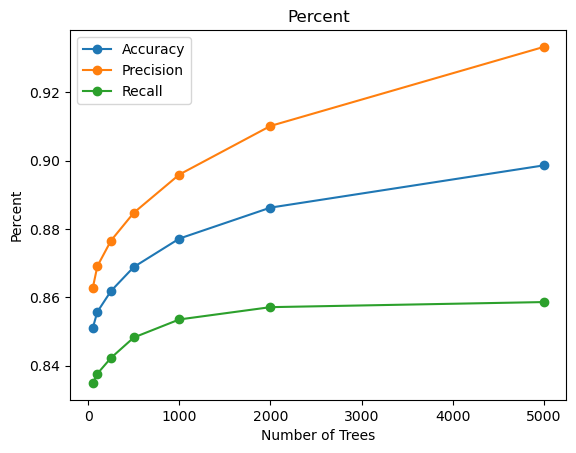

In [93]:
array = {'Accuracy' :  cross_validate_result, 
        'Precision' :  cross_validate_precision ,
        'Recall' :  cross_validate_recall}

pd.DataFrame(array).plot(kind='line', marker='o')
# Display the plot
plt.title('Percent')
plt.xlabel('Number of Trees')
plt.ylabel('Percent')
plt.show()

# Model 8 : XGBoost

In [177]:

X_smote_xg = X_smote.rename(columns={'age_<25': 'less_than_25'})
X_OOS_test_xg = X_OOS_test.rename(columns={'age_<25': 'less_than_25'})

dtrain = xgb.DMatrix(X_smote_xg, label=y_smote)
dtest = xgb.DMatrix(X_OOS_test_xg, label=y_OOS_test)

# Set hyperparameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8
}

XGBoost = XGBClassifier(objective='binary:logistic', random_state=42,n_estimators=200,max_depth=7,learning_rate=0.1)
XGBoost.fit(X_smote_xg,y_smote)

threshold = 0.5

# Make predictions on the test set
y_pred_prob = XGBoost.predict(X_OOS_test_xg)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred_prob]


[0 0 0 ... 0 0 0]


### Confusion Matrix for XGBoost 

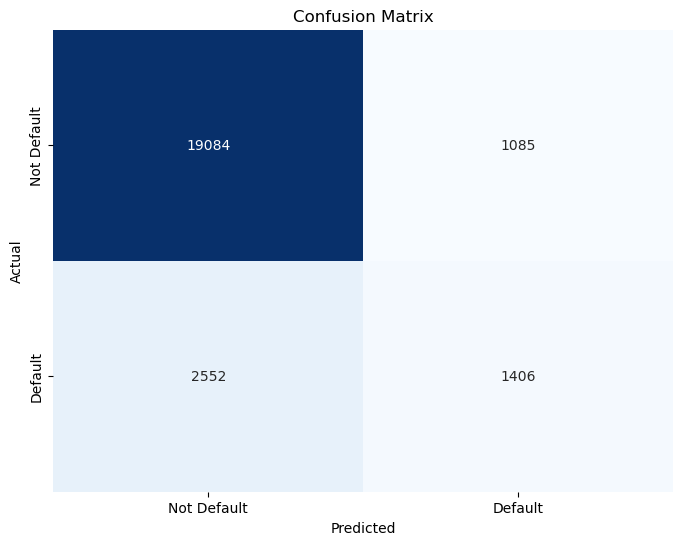

In [176]:
# Compute the confusion matrix
cm = confusion_matrix(y_OOS_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Cross Validation for XGBoost

In [26]:
from xgboost import XGBClassifier  # Assuming you are using XGBoost for classification; use XGBRegressor for regression

XGBoost = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the hyperparameters and their respective values to be explored
param_grid = {
    'max_depth': [1, 3, 5, 10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [50, 100, 200, 300, 500 ]
    # Add more hyperparameters and values as needed
}

# Create the GridSearchCV object
scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
grid_search = GridSearchCV(XGBoost, param_grid, cv=cv, scoring=scoring,refit='precision', n_jobs=-1)

# Fit the model with different hyperparameter combinations
grid_search.fit(X_smote_xg, y_smote)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f'Best Hyperparameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_accuracy:.4f}')

# Model 9 : Changing the threshold for XGBoost  

### XGBoost Cross Validate to find the best threshold

In [190]:
# CV in Trees 
# Set Hyperparameter (Lambda) values to cross validate here !!!!!
thresholds = [0.2, 0.25, 0.3 , 0.35, 0.4, 0.45, 0.5 ] 

cross_validate_result = {}
cross_validate_recall = {} 
cross_validate_precision = {} 

for threshold in thresholds: 
    print('Threshold : ', threshold)
    accuracies = []
    recall_scores = [] 
    precision_scores = [] 
    XGBoost = xgb.XGBRegressor(objective='reg:squarederror', seed=42,n_estimators=200,max_depth=7,learning_rate=0.1)
    for train_index, test_index in cv.split(X_smote_xg):
        # change to loc to define the rows in the dataframe 
        X_cv_train, X_cv_test, y_cv_train, y_cv_test = X_smote_xg.iloc[train_index], X_smote_xg.iloc[test_index], y_smote.iloc[train_index], y_smote.iloc[test_index]
        XGBoost.fit(X_cv_train, y_cv_train)
        y_pred_prob = XGBoost.predict(X_cv_test)

        # Make predictions on the test set
        y_pred = [1 if pred > threshold else 0 for pred in y_pred_prob]

        #Cross-Validation Prediction Error

        accuracies.append(accuracy_score(y_cv_test, y_pred))
        recall_scores.append(recall_score(y_cv_test, y_pred))
        precision_scores.append(precision_score(y_cv_test,y_pred))
    
    cross_validate_result[threshold * 100] = (sum(accuracies)/len(accuracies))
    cross_validate_recall[threshold * 100] = (sum(recall_scores)/len(recall_scores))
    cross_validate_precision[threshold * 100] = (sum(precision_scores)/len(precision_scores))

    print("Accuracy : " + str((sum(accuracies)/len(accuracies))))
    print("Precision : " + str((sum(recall_scores)/len(recall_scores))))
    print("Recall : " + str((sum(precision_scores)/len(precision_scores))))
    print() 
    
# At the end you'll see what the value of each LASSO paramter is
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ',cross_validate_precision)
print('Recall : ',cross_validate_recall)

Threshold :  0.2
Accuracy : 0.8027694900826683
Precision : 0.9457185400672257
Recall : 0.7354633165013805

Threshold :  0.25
Accuracy : 0.8371035432428636
Precision : 0.9311525271309199
Recall : 0.7837398023365946

Threshold :  0.3
Accuracy : 0.8619708267882912
Precision : 0.9177758575914524
Recall : 0.825635414616092

Threshold :  0.35
Accuracy : 0.880025749442205
Precision : 0.9037939689462094
Recall : 0.862795756032224

Threshold :  0.4
Accuracy : 0.8917818594021367
Precision : 0.8886419860204237
Recall : 0.8942637174307843

Threshold :  0.45
Accuracy : 0.8984209772795794
Precision : 0.8731882745005818
Recall : 0.9196055320065014

Threshold :  0.5
Accuracy : 0.8997883997231677
Precision : 0.8559396590819375
Recall : 0.9382287573383132

------------------
Accuracy :  {20.0: 0.8027694900826683, 25.0: 0.8371035432428636, 30.0: 0.8619708267882912, 35.0: 0.880025749442205, 40.0: 0.8917818594021367, 45.0: 0.8984209772795794, 50.0: 0.8997883997231677}
Precision :  {20.0: 0.7354633165013805

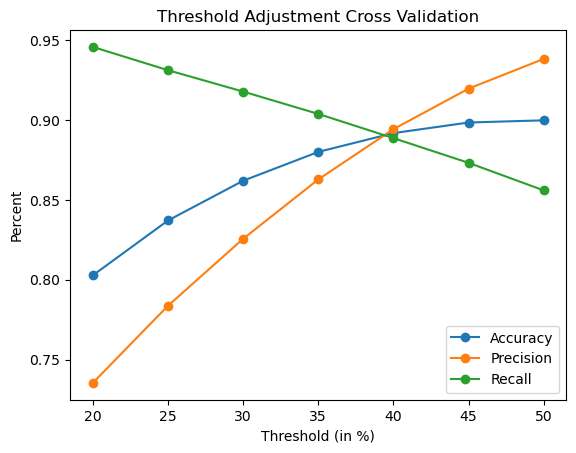

In [193]:
array = {'Accuracy' :  cross_validate_result, 
        'Precision' :  cross_validate_precision ,
        'Recall' :  cross_validate_recall}
pd.DataFrame(array).plot(kind='line', marker='o')

# Display the plot
plt.title('Threshold Adjustment Cross Validation')
plt.xlabel('Threshold (in %)')
plt.ylabel('Percent')
plt.show()

In [194]:
threshold = 0.4
# Make predictions on the test set
y_pred_prob = XGBoost.predict(X_OOS_test_xg)
y_pred = [1 if pred > threshold else 0 for pred in y_pred_prob]

# Final Results for XGBoost with adjusted threshold to 0.4 for predicting default 

In [195]:
print("XGBoost Accuracy : " , accuracy_score(y_OOS_test, y_pred))
print("XGBoost Recall : " , recall_score(y_OOS_test, y_pred))
print("XGBoost Precision : ", precision_score(y_OOS_test,y_pred))
print("XGBoost MSE : ", mean_squared_error(y_OOS_test,y_pred))
print("XGBoost f1 : ", f1_score(y_OOS_test,y_pred))

XGBoost Accuracy :  0.8194553819372488
XGBoost Recall :  0.44871147043961596
XGBoost Precision :  0.44962025316455695
XGBoost MSE :  0.18054461806275127
XGBoost f1 :  0.44916540212443096
